In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
athletes_df= pd.read_csv('athlete_events.csv')
noc_df= pd.read_csv('noc_regions.csv')

In [ ]:
athletes_df.head(5)

In [ ]:
athletes_df.tail(5)

In [ ]:
athletes_df.info()

In [ ]:
noc_df.head(66)

In [ ]:
noc_df.info()

In [ ]:
noc_df.isnull().sum()

In [ ]:
filt=athletes_df['Name']=='Per Knut Aaland'
athletes_df[filt]

## Database Setup

In [3]:
from sqlalchemy import create_engine ,MetaData, inspect ,Table,Column,String,Integer,Boolean, ForeignKey ,select,func,desc ,text ,delete

In [6]:
engine= create_engine('sqlite:///olympics.db')

In [ ]:
inspector= inspect(engine)
tables = inspector.get_table_names()

print(tables)

In [7]:
connection=engine.connect()


In [ ]:
metadata=MetaData()

In [ ]:
metadata.reflect(bind=engine)

In [ ]:
Athletes = Table(
    'athletes',
    metadata,
    Column('Ath_ID', Integer(), primary_key=True, autoincrement=False),
    Column('Name', String(255)),
    Column('Sex', String(1)),
    Column('Age', Integer()),
    Column('Height', Integer()),
    Column('Weight', Integer())
)
NOC_Countries = Table(
    'noc_countries',
    metadata,
    Column('NOC', String(3), primary_key=True),
    Column('Region', String(255)),
    Column('Text', String(255))
)


Sports = Table(
    'sports',
    metadata,
    Column('Sport_ID', Integer(), primary_key=True),
    Column('Sport_Name', String(255), unique=True)
)


Games = Table(
    'games',
    metadata,
    Column('Games_ID', Integer(), primary_key=True),
    Column('Year', Integer()),
    Column('Season', String(255)),
    Column('City', String(255)),
    Column('Game_name', String(255))
)


Events = Table(
    'events',
    metadata,
    Column('Event_ID', Integer(), primary_key=True),
    Column('Sport_ID', Integer(), ForeignKey('sports.Sport_ID')),
    Column('Event_Name', String(255))
)


Results = Table(
    'results',
    metadata,
    Column('Result_ID', Integer(), primary_key=True),
    Column('Ath_ID', Integer(), ForeignKey('athletes.Ath_ID')),
    Column('NOC', String(3), ForeignKey('noc_countries.NOC')),
    Column('Game_ID', Integer(), ForeignKey('games.Games_ID')),
    Column('Event_ID', Integer(), ForeignKey('events.Event_ID')),
    Column('Medal', String(255))
)
metadata.create_all(engine)

# insert into tables 

### noc_countries Table

In [ ]:
noc_df.head()
noc_countries = noc_df[['NOC','region','notes']]\
    .rename(columns={'region':'Region','notes':'Text'})\
    .drop_duplicates(subset=['NOC'])

noc_countries.to_sql(
    name='noc_countries',
    con=engine,
    if_exists='append',
    index=False
)

In [ ]:
stmt=text('SELECT * FROM noc_countries')
res=connection.execute(stmt).fetchmany(10)
for result in res :
    print (result)



### sports Table

In [ ]:
athletes_df.head()
sports = athletes_df[['Sport']] \
    .rename(columns={'Sport':'Sport_Name'})\
    .drop_duplicates() \
    .reset_index(drop=True)
sports['Sport_ID'] = sports.index + 1
sports.to_sql(
    name='sports',
    con=engine,
    if_exists='append',
    index=False
)



In [ ]:
sports.tail(5)

In [ ]:
stmt=text('SELECT * FROM sports')
res=connection.execute(stmt).fetchall()
for result in res :
    print (result)

In [ ]:
sports.isnull().sum()

In [ ]:
sports.tail(10)

### Games Table

In [ ]:
athletes_df.head()
games_df = athletes_df[['Year','Season','City','Games']] \
    .rename(columns={'Games' : 'Game_name'}) \
    .drop_duplicates() \
    .reset_index(drop=True)
games_df ['Games_ID']=games_df.index+1

games_df.head()

In [ ]:
games_df.isnull().sum()

In [ ]:
games_df.count()

In [ ]:
games_df.to_sql(
    name='games',
    con=engine,
    if_exists='replace',
    index=False
)

In [ ]:
stmt = text('SELECT Games_ID, Year, Season, City, Game_name FROM games ORDER BY Games_ID ASC')
res = connection.execute(stmt).fetchall()
for result in res:
    print(result)


### Athletes Table

In [ ]:
athletes_df.head(5)
AthletesMini_df=athletes_df[['ID','Name','Sex','Age','Height','Weight']]\
    .rename(columns={'ID':'Ath_ID'})\
    .drop_duplicates(subset=['Ath_ID'])
AthletesMini_df.head()
AthletesMini_df.isnull().sum()

In [ ]:
# fixing the null values of height , age , Weight
# Convert to numeric first
AthletesMini_df['Age'] = pd.to_numeric(AthletesMini_df['Age'], errors='coerce')
AthletesMini_df['Height'] = pd.to_numeric(AthletesMini_df['Height'], errors='coerce')
AthletesMini_df['Weight'] = pd.to_numeric(AthletesMini_df['Weight'], errors='coerce')

AthletesMini_df['Age'] = AthletesMini_df['Age'].fillna(AthletesMini_df['Age'].median())
AthletesMini_df['Height'] = AthletesMini_df['Height'].fillna(AthletesMini_df['Height'].median())
AthletesMini_df['Weight'] = AthletesMini_df['Weight'].fillna(AthletesMini_df['Weight'].median())

In [ ]:
AthletesMini_df.isnull().sum()

In [ ]:
AthletesMini_df.head()

In [ ]:
AthletesMini_df.to_sql(
    name='athletes',
    con=engine,
    if_exists='append',
    index=False
)

In [ ]:
stmt=text('SELECT * FROM athletes')
res=connection.execute(stmt).fetchmany(100)
for result in res :
    print (result)


In [ ]:
stmt=text('DROP TABLE IF EXISTS athlete')
res=connection.execute(stmt)


### events Table

In [ ]:
events_df = (
    athletes_df[['Sport', 'Event']]
    .drop_duplicates()
    .merge(sports, left_on='Sport', right_on='Sport_Name')
    .rename(columns={'Event': 'Event_Name'})
    [['Event_Name', 'Sport_ID']]  
    .reset_index(drop=True)
)


events_df['Event_ID'] = events_df.index + 1


events_df = events_df[['Event_ID', 'Sport_ID', 'Event_Name']]
events_df.tail(5)

In [ ]:
events_df.tail(5)

In [ ]:
events_df.head(5)

In [ ]:
events_df.isnull().sum()

In [ ]:
events_df.to_sql(
    name='events',
    con=engine,
    if_exists='append',
    index=False
)


### results Table

In [ ]:
results_df = (
    athletes_df
    .merge(
        games_df,
        on=['Year', 'Season', 'City'],
        how='left'
    )
    .merge(
        events_df,
        left_on=['Event'],
        right_on=['Event_Name'],
        how='left'
    )
    [['ID', 'NOC', 'Games_ID', 'Event_ID', 'Medal']]
    .rename(columns={'ID': 'Ath_ID' ,'Games_ID': 'Game_ID'})
    .drop_duplicates()
    .reset_index(drop=True)
)


results_df['Result_ID'] = results_df.index + 1


results_df = results_df[['Result_ID', 'Ath_ID', 'NOC', 'Game_ID', 'Event_ID', 'Medal']]


In [ ]:
results_df.head(5)

In [ ]:
results_df.tail(5)

In [ ]:
results_df.isnull().sum()

In [ ]:
print("Columns in results_df:", results_df.columns)

In [ ]:
results_df.to_sql(
    name='results',
    con=engine,
    if_exists='replace',
    index=False,
)

# checker

In [90]:
stmt = text('SELECT Games_ID, Year, Season, City, Game_name FROM games ORDER BY Games_ID ASC')
res = connection.execute(stmt).fetchmany(10)
for result in res:
    print(result)


(1, 1992, 'Summer', 'Barcelona', '1992 Summer')
(2, 2012, 'Summer', 'London', '2012 Summer')
(3, 1920, 'Summer', 'Antwerpen', '1920 Summer')
(4, 1900, 'Summer', 'Paris', '1900 Summer')
(5, 1988, 'Winter', 'Calgary', '1988 Winter')
(6, 1992, 'Winter', 'Albertville', '1992 Winter')
(7, 1994, 'Winter', 'Lillehammer', '1994 Winter')
(8, 1932, 'Summer', 'Los Angeles', '1932 Summer')
(9, 2002, 'Winter', 'Salt Lake City', '2002 Winter')
(10, 1952, 'Summer', 'Helsinki', '1952 Summer')


In [ ]:
stmt=text('SELECT * FROM noc_countries')
res=connection.execute(stmt).fetchmany(10)
for result in res :
    print (result)


In [ ]:
stmt=text('SELECT * FROM athletes')
res=connection.execute(stmt).fetchmany(10)
for result in res :
    print (result)


In [ ]:
stmt=text('SELECT * FROM events')
res=connection.execute(stmt).fetchmany(10)
for result in res :
    print (result)


In [ ]:
stmt=text('SELECT * FROM sports')
res=connection.execute(stmt).fetchmany(10)
for result in res :
    print (result)


In [ ]:
stmt=text('SELECT * FROM results')
res=connection.execute(stmt).fetchmany(10)
for result in res :
    print (result)


# Analysis

## Which country won the most gold medals in the Winter Olympics?

In [91]:
query1 = text("""
SELECT c.Region AS Country, COUNT(r.Medal) AS GoldMedals
FROM results r
JOIN noc_countries c ON r.NOC = c.NOC
JOIN games g ON r.Game_ID = g.Games_ID
WHERE r.Medal = 'Gold' AND g.Season = 'Winter'
GROUP BY c.Region
ORDER BY GoldMedals DESC
LIMIT 5;
""")
res = connection.execute(query1).fetchall()
for result in res:
    print(result)

('Russia', 379)
('Canada', 305)
('Germany', 226)
('USA', 166)
('Norway', 151)


In [34]:
df_query1 = pd.read_sql(query1, con=engine)
print(df_query1)

   Country  GoldMedals
0   Russia         379
1   Canada         305
2  Germany         226
3      USA         166
4   Norway         151


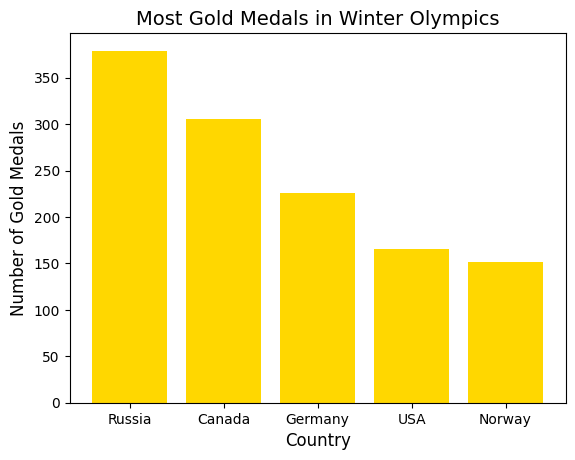

In [36]:
plt.bar(df_query1['Country'],df_query1['GoldMedals'],color='gold')
plt.title('Most Gold Medals in Winter Olympics',fontsize=14)
plt.xlabel('Country',fontsize=12)
plt.ylabel('Number of Gold Medals',fontsize=12)
plt.grid=True
plt.show()


## What is the distribution of athlete ages in different sports

In [39]:
query2 = text("""
SELECT s.Sport_Name AS Sport, 
       ROUND(AVG(a.Age),1) AS AvgAge,
       MIN(a.Age) AS MinAge,
       MAX(a.Age) AS MaxAge
FROM athletes a
JOIN results r ON a.Ath_ID = r.Ath_ID
JOIN events e ON r.Event_ID = e.Event_ID
JOIN sports s ON e.Sport_ID = s.Sport_ID
GROUP BY s.Sport_Name
ORDER BY COUNT(*) DESC
LIMIT 10;
""")
res = connection.execute(query2).fetchall()
for result in res:
    print(result)

('Athletics', 23.5, 12, 48)
('Gymnastics', 21.4, 10, 49)
('Swimming', 19.1, 11, 41)
('Shooting', 29.7, 15, 68)
('Cycling', 23.3, 14, 43)
('Fencing', 25.5, 14, 63)
('Rowing', 23.7, 11, 60)
('Cross Country Skiing', 23.5, 15, 47)
('Alpine Skiing', 21.3, 14, 45)
('Wrestling', 24.1, 14, 50)


In [40]:
df_query2 = pd.read_sql(query2, con=engine)
print(df_query2)

                  Sport  AvgAge  MinAge  MaxAge
0             Athletics    23.5      12      48
1            Gymnastics    21.4      10      49
2              Swimming    19.1      11      41
3              Shooting    29.7      15      68
4               Cycling    23.3      14      43
5               Fencing    25.5      14      63
6                Rowing    23.7      11      60
7  Cross Country Skiing    23.5      15      47
8         Alpine Skiing    21.3      14      45
9             Wrestling    24.1      14      50


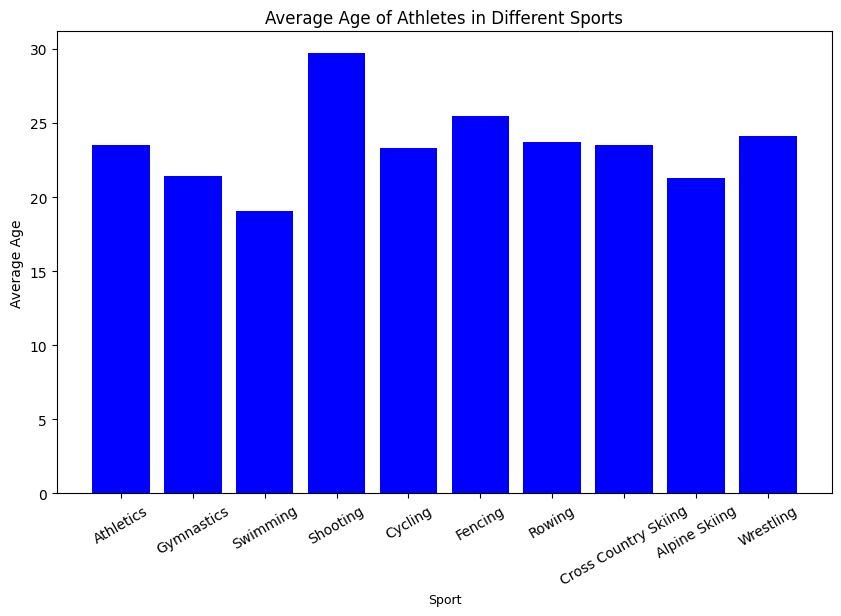

In [48]:
plt.figure(figsize=(10, 6))
plt.bar(df_query2['Sport'], df_query2['AvgAge'], color='blue')
plt.title('Average Age of Athletes in Different Sports')
plt.xlabel('Sport',fontsize=9)
plt.ylabel('Average Age')
plt.xticks(rotation=30)
plt.show()

## List the top 10 athletes with the most total medals?

In [49]:
query3=text("""
SELECT 
    a.Name,
    COUNT(*) AS Total_Medals
FROM results r
JOIN athletes a ON r.Ath_ID = a.Ath_ID
WHERE r.Medal IS NOT NULL
GROUP BY a.Name
ORDER BY Total_Medals DESC
LIMIT 10;
""")
res = connection.execute(query3).fetchall()
for result in res:
    print(result)

('Michael Fred Phelps, II', 28)
('Larysa Semenivna Latynina (Diriy-)', 18)
('Nikolay Yefimovich Andrianov', 15)
('Takashi Ono', 13)
('Ole Einar Bjrndalen', 13)
('Edoardo Mangiarotti', 13)
('Borys Anfiyanovych Shakhlin', 13)
('Sawao Kato', 12)
('Ryan Steven Lochte', 12)
('Paavo Johannes Nurmi', 12)


In [50]:
df_query3 = pd.read_sql(query3, con=engine)
print(df_query3)

                                 Name  Total_Medals
0             Michael Fred Phelps, II            28
1  Larysa Semenivna Latynina (Diriy-)            18
2        Nikolay Yefimovich Andrianov            15
3                         Takashi Ono            13
4                 Ole Einar Bjrndalen            13
5                 Edoardo Mangiarotti            13
6         Borys Anfiyanovych Shakhlin            13
7                          Sawao Kato            12
8                  Ryan Steven Lochte            12
9                Paavo Johannes Nurmi            12


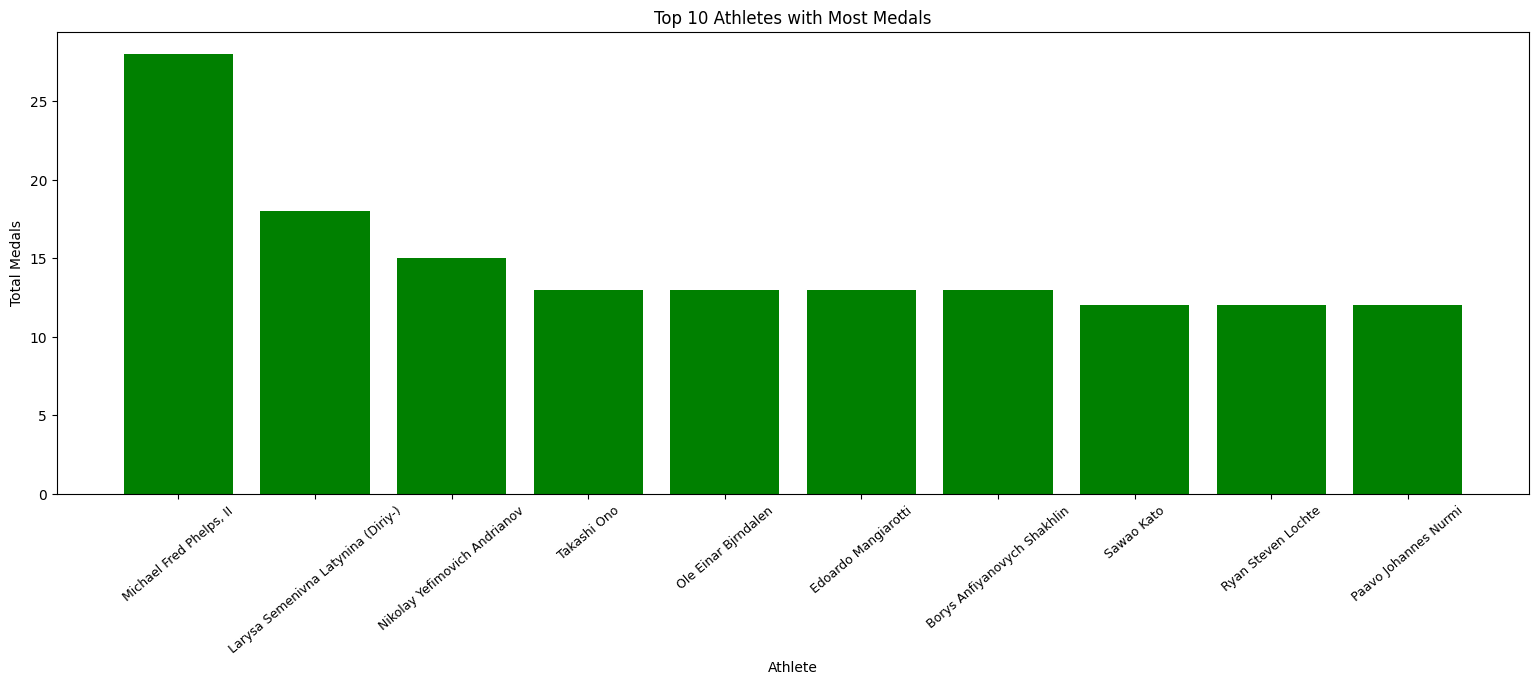

In [73]:
plt.figure(figsize=(19, 6))
plt.bar(df_query3['Name'], df_query3['Total_Medals'], color='green')
plt.title('Top 10 Athletes with Most Medals')
plt.xlabel('Athlete',fontsize=10)
plt.ylabel('Total Medals')
plt.xticks(rotation=40,fontsize=9)
plt.show()

## Which cities have hosted both the Summer and Winter Olympics?

In [ ]:
query4=text("""
SELECT City
FROM GAMES
GROUP BY City
HAVING COUNT(DISTINCT Season) = 2;

""")


res = connection.execute(query4).fetchall()
for result in res:
    print(result)           #  the answer is no country have done that

## Analyze the trend of athlete participation over the years

In [12]:
query5=text("""
SELECT 
    g.Year,
    COUNT(DISTINCT r.Ath_ID) AS Athlete_Count
FROM results r
JOIN games g ON r.Game_ID = g.Games_ID
GROUP BY g.Year
ORDER BY g.Year;

""")


res = connection.execute(query5).fetchall()
for result in res:
    print(result)


(1896, 176)
(1900, 1224)
(1904, 650)
(1906, 841)
(1908, 2024)
(1912, 2409)
(1920, 2676)
(1924, 3565)
(1928, 3703)
(1932, 2174)
(1936, 5142)
(1948, 5068)
(1952, 5622)
(1956, 4167)
(1960, 6017)
(1964, 6230)
(1968, 6717)
(1972, 8122)
(1976, 7200)
(1980, 6330)
(1984, 8067)
(1988, 9873)
(1992, 11183)
(1994, 1738)
(1996, 10339)
(1998, 2179)
(2000, 10647)
(2002, 2399)
(2004, 10557)
(2006, 2494)
(2008, 10899)
(2010, 2536)
(2012, 10517)
(2014, 2745)
(2016, 11179)


In [13]:
df_query5 = pd.read_sql(query5, con=engine)
print(df_query5)

    Year  Athlete_Count
0   1896            176
1   1900           1224
2   1904            650
3   1906            841
4   1908           2024
5   1912           2409
6   1920           2676
7   1924           3565
8   1928           3703
9   1932           2174
10  1936           5142
11  1948           5068
12  1952           5622
13  1956           4167
14  1960           6017
15  1964           6230
16  1968           6717
17  1972           8122
18  1976           7200
19  1980           6330
20  1984           8067
21  1988           9873
22  1992          11183
23  1994           1738
24  1996          10339
25  1998           2179
26  2000          10647
27  2002           2399
28  2004          10557
29  2006           2494
30  2008          10899
31  2010           2536
32  2012          10517
33  2014           2745
34  2016          11179


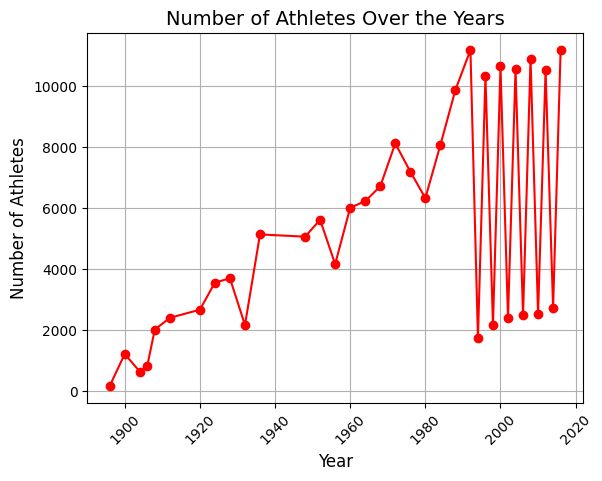

In [28]:
plt.plot(df_query5['Year'], df_query5['Athlete_Count'],color='red', marker='o', linestyle='-')
plt.title('Number of Athletes Over the Years',fontsize=14)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Number of Athletes',fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()